In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore, shapiro, ttest_ind, ttest_rel, f_oneway, pearsonr, iqr, norm, ttest_1samp
from scipy.special import comb

# Data inladen
pd.set_option('display.max_columns', None)
df_co2 = pd.read_excel('Mobiliteitsdata.xlsx')
print("Eerste rijen van de dataset:")
display(df_co2.head())
print("Kolommen in de dataset:")
display(df_co2.columns.tolist())
pd.set_option('display.max_columns', 10)

# Verwijder 'anders' geslacht (slechts 2 waarden)
df_co2 = df_co2[df_co2['geslacht'].isin(['man', 'vrouw'])]
print("Aantal per geslacht na opschoning:")
display(df_co2['geslacht'].value_counts())

Eerste rijen van de dataset:


,persoon_ID,geslacht,leeftijd,gewicht_KG,burgerlijke_staat,jaarsalaris_eu,huishouden_grootte,stad,provincie,opleiding_niveau,autobezit,fietsbezit,elektrisch_auto,km_auto_per_jaar,km_fiets_per_jaar,km_ov_per_jaar,km_vliegtuig_per_jaar,dagen_thuiswerken_per_week_pro_rato,dagen_kantoorwerken_per_week_pro_rato,dagen_in_buitenland_per_jaar,gebruik_carsharing,co2_uitstoot_per_jaar_KG
0,811069,man,50,52.66,weduwe/weduwnaar,48003.64,5,Almere,Flevoland,MBO,ja,ja,nee,13266.05,2040.54,3227.95,480.71,4,1,20,Nooit,7591.93
1,246882,vrouw,65,64.58,samenwonend,55208.63,2,Leeuwarden,Overijssel,WO,ja,nee,nee,15229.89,0.00,2298.96,1423.34,5,0,7,Heel soms,8742.25
2,978385,man,49,90.87,samenwonend,29533.78,2,Tilburg,Utrecht,HBO,ja,ja,ja,19853.24,1540.46,4504.21,632.48,4,1,2,Altijd,4513.56
3,120468,man,34,80.43,gehuwd,44453.27,2,Maastricht,Utrecht,HBO,ja,ja,nee,9935.50,1825.92,4407.56,1266.84,3,2,21,Heel soms,6904.41
4,637034,man,60,72.28,ongehuwd,56497.64,2,Leiden,Gelderland,MBO,ja,ja,ja,16266.67,1851.07,1936.12,1676.00,0,5,0,Nooit,4420.80


Kolommen in de dataset:


['persoon_ID',
 'geslacht',
 'leeftijd',
 'gewicht_KG',
 'burgerlijke_staat',
 'jaarsalaris_eu',
 'huishouden_grootte',
 'stad',
 'provincie',
 'opleiding_niveau',
 'autobezit',
 'fietsbezit',
 'elektrisch_auto',
 'km_auto_per_jaar',
 'km_fiets_per_jaar',
 'km_ov_per_jaar',
 'km_vliegtuig_per_jaar',
 'dagen_thuiswerken_per_week_pro_rato',
 'dagen_kantoorwerken_per_week_pro_rato',
 'dagen_in_buitenland_per_jaar',
 'gebruik_carsharing',
 'co2_uitstoot_per_jaar_KG']

Aantal per geslacht na opschoning:


geslacht
vrouw    778
man      720
Name: count, dtype: int64

# Deel A: Data exploratie en voorbereiding

1.	Geef voor elke variabele in de dataset weer tot welk meetniveau deze behoort.

In [25]:
# 1
# We bepalen het meetniveau van elke variabele om te weten welke analyses en transformaties mogelijk zijn. Dit is belangrijk omdat het meetniveau bepaalt welke statistische methodes we kunnen gebruiken.
# We hebben persoon_ID weggelaten in analyses, omdat het geen statistische waarde heeft.

| Variabele | Meetniveau | Uitleg |
|-----------|------------|--------|
| persoon_ID | Geen | Unieke identifier, geen statistische waarde |
| geslacht | Nominaal | Categorisch (man/vrouw), geen rangorde |
| leeftijd | Ratio | Continue waarde met absoluut nulpunt |
| gewicht_KG | Ratio | Continue waarde met absoluut nulpunt |
| burgerlijke_staat | Nominaal | Categorisch (bijv. gehuwd, ongehuwd), geen rangorde |
| jaarsalaris_eu | Ratio | Continue waarde, behandeld als numeriek |
| huishouden_grootte | Ratio | Numeriek, aantal personen in huishouden |
| stad | Nominaal | Categorisch, geen rangorde |
| provincie | Nominaal | Categorisch, geen rangorde |
| opleiding_niveau | Ordinaal | Rangorde (MBO < HBO < WO) |
| autobezit | Nominaal | Binair (ja/nee) |
| fietsbezit | Nominaal | Binair (ja/nee) |
| elektrisch_auto | Nominaal | Binair (ja/nee) |
| km_auto_per_jaar | Ratio | Continue waarde, aantal kilometers |
| km_fiets_per_jaar | Ratio | Continue waarde, aantal kilometers |
| km_ov_per_jaar | Ratio | Continue waarde, aantal kilometers |
| km_vliegtuig_per_jaar | Ratio | Continue waarde, aantal kilometers |
| dagen_thuiswerken_per_week_pro_rato | Ratio | Continue waarde, aantal dagen |
| dagen_kantoorwerken_per_week_pro_rato | Ratio | Continue waarde, aantal dagen |
| dagen_in_buitenland_per_jaar | Ratio | Continue waarde, aantal dagen |
| gebruik_carsharing | Ordinaal | Categorisch met rangorde (nooit, soms, vaak) |
| co2_uitstoot_per_jaar_KG | Ratio | Continue waarde, hoeveelheid CO₂ |

2.	Waarom is het nodig om vooraf te bekijken tot welk meetniveau elke variabele behoort?

Het meetniveau bepaalt hoe we variabelen analyseren en voorbewerken. Nominale variabelen vragen om dummyvariabelen, ordinale om mapping naar numerieke waarden, en ratio/interval om standaardisatie. Zonder deze stap riskeren we verkeerde methodes, wat de analyse onbetrouwbaar maakt.

In [26]:
# 2

3.	Ga na of er missende/niet kloppende/extreme waarden zijn in de dataset en ga hier op een adequate manier mee om.

We controleren op missende, negatieve en extreme waarden om een schone dataset te garanderen.

Missende waarden percentage:
co2_uitstoot_per_jaar_KG    0.47
jaarsalaris_eu              0.07
stad                        0.07
opleiding_niveau            0.07
autobezit                   0.07
dtype: float64
Extreme waarden in gewicht_KG: 3


C:\Users\mkako\AppData\Local\Temp\ipykernel_20952\883087583.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_co2[col].fillna(df_co2[col].median(), inplace=True)
C:\Users\mkako\AppData\Local\Temp\ipykernel_20952\883087583.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

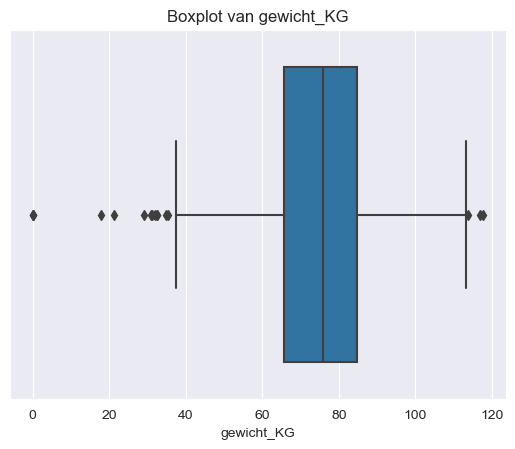

In [27]:
# 3
# Verwijder persoon_ID
if 'persoon_ID' in df_co2.columns:
    df_co2 = df_co2.drop('persoon_ID', axis=1)

# Missende waarden
mv = df_co2.isnull().mean() * 100
print("Missende waarden percentage:")
print(mv[mv > 0].sort_values(ascending=False).round(2))

# Strategie: numerieke kolommen vullen met mediaan (robuust), categorische met modus
numeric_cols = df_co2.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_co2[col].isnull().any():
        df_co2[col].fillna(df_co2[col].median(), inplace=True)

categorical_cols = df_co2.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_co2[col].isnull().any():
        df_co2[col].fillna(df_co2[col].mode()[0], inplace=True)

# Negatieve waarden naar NaN
foute_kolommen = ['km_auto_per_jaar', 'km_ov_per_jaar']
for col in foute_kolommen:
    df_co2.loc[df_co2[col] < 0, col] = df_co2[col].median()

# Extreme waarden detecteren met IQR
for col in numeric_cols:
    Q1 = df_co2[col].quantile(0.25)
    Q3 = df_co2[col].quantile(0.75)
    IQR = Q3 - Q1
    laag = Q1 - 2.5 * IQR
    hoog = Q3 + 2.5 * IQR
    extreem_aantal = ((df_co2[col] < laag) | (df_co2[col] > hoog)).sum()
    if extreem_aantal > 0:
        print(f"Extreme waarden in {col}: {extreem_aantal}")
        sns.boxplot(x=df_co2[col])
        plt.title(f"Boxplot van {col}")
        plt.show()

**Uitleg**: We vullen missende waarden aan met de mediaan (numeriek) of modus (categorisch) vanwege robuustheid. Negatieve waarden in `km_auto_per_jaar` en `km_ov_per_jaar` worden vervangen door de mediaan, omdat negatieve kilometers onlogisch zijn. Extreme waarden worden gedetecteerd met IQR, maar we behouden ze voorlopig, omdat ze geen grote verstoring veroorzaken.

4.	Kies 2 onafhankelijke variabelen waarvan je denkt dat het invloed kan hebben op de jaarlijkse CO2 uitstoot. Visualiseer de verdeling van deze twee variabelen en de verdeling van de afhankelijke variabele.

We kiezen `km_auto_per_jaar` en `km_vliegtuig_per_jaar`, omdat deze vervoersmiddelen veel brandstof gebruiken en waarschijnlijk een grote impact hebben op CO₂-uitstoot. We gebruiken histogrammen en scatterplots om de verdeling en relaties te bekijken.We kiezen `km_auto_per_jaar` en `km_vliegtuig_per_jaar`, omdat deze vervoersmiddelen veel brandstof gebruiken en waarschijnlijk een grote impact hebben op CO₂-uitstoot. We gebruiken histogrammen en scatterplots om de verdeling en relaties te bekijken.

C:\Users\mkako\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


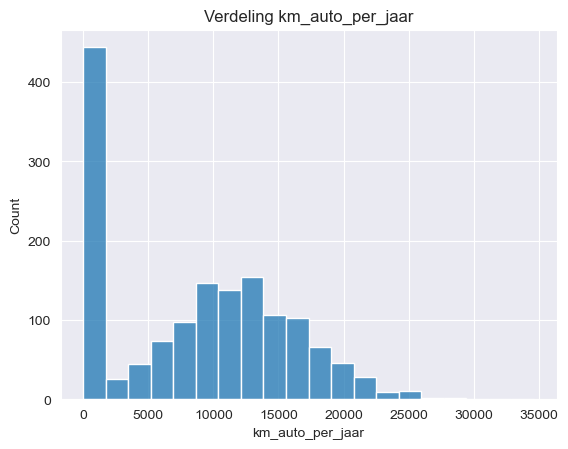

C:\Users\mkako\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


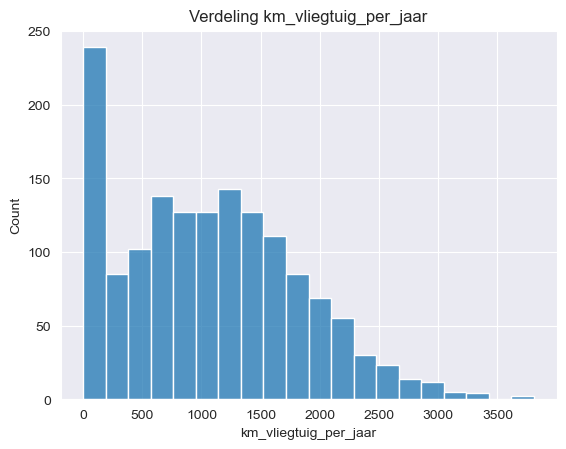

C:\Users\mkako\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


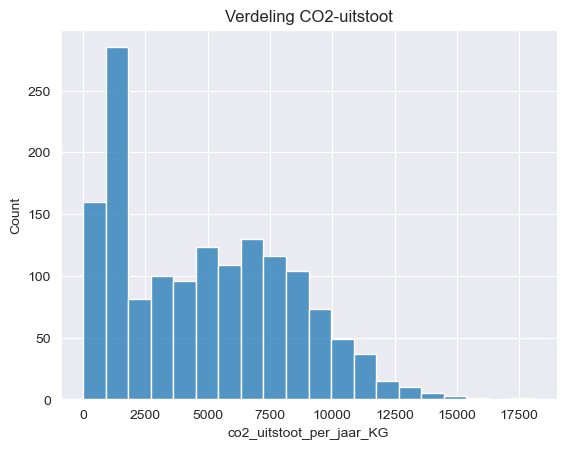

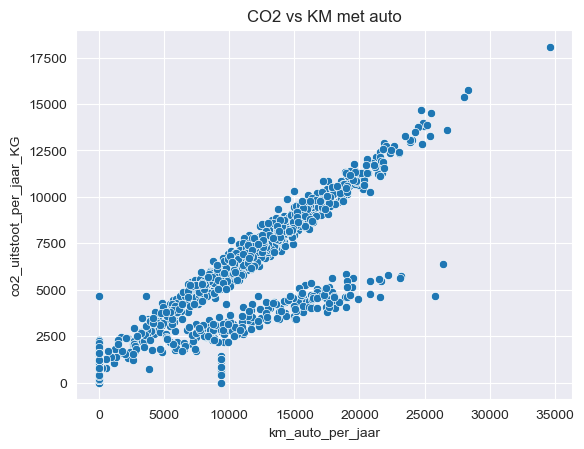

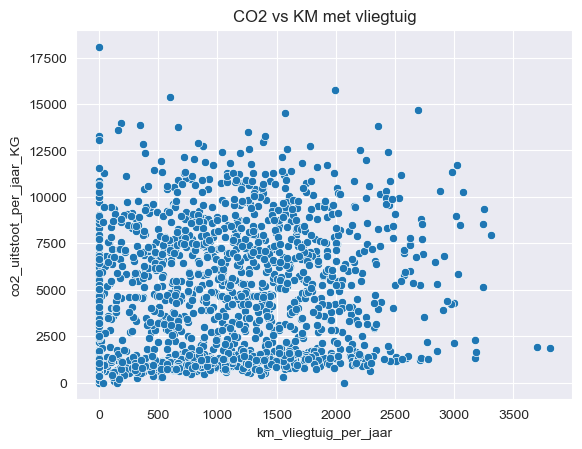

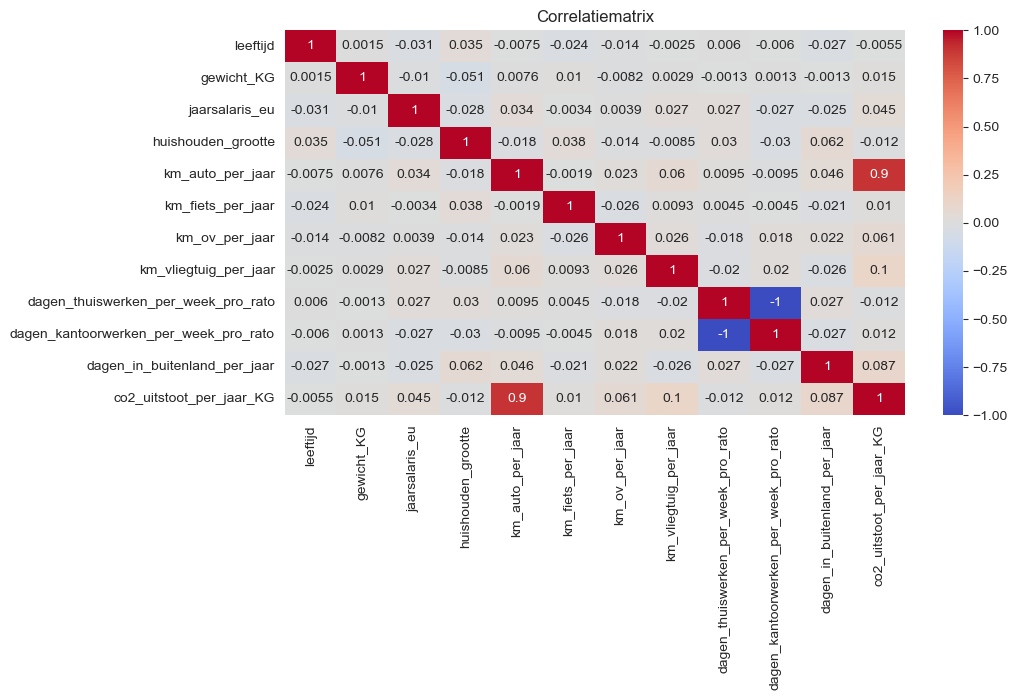

In [28]:
# 4
# Visualisaties
def hist_plot_maker(data, x, title):
    sns.histplot(data=data, x=x, kde=False, bins=20)
    plt.title(title)
    plt.show()

hist_plot_maker(df_co2, 'km_auto_per_jaar', 'Verdeling km_auto_per_jaar')
hist_plot_maker(df_co2, 'km_vliegtuig_per_jaar', 'Verdeling km_vliegtuig_per_jaar')
hist_plot_maker(df_co2, 'co2_uitstoot_per_jaar_KG', 'Verdeling CO2-uitstoot')

# Scatterplots
sns.scatterplot(x='km_auto_per_jaar', y='co2_uitstoot_per_jaar_KG', data=df_co2)
plt.title('CO2 vs KM met auto')
plt.show()
sns.scatterplot(x='km_vliegtuig_per_jaar', y='co2_uitstoot_per_jaar_KG', data=df_co2)
plt.title('CO2 vs KM met vliegtuig')
plt.show()

# Correlatiematrix
numeric_cols = df_co2.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 5))
sns.heatmap(df_co2[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlatiematrix")
plt.show()

**Uitleg**: De heatmap toont dat `km_auto_per_jaar` een sterke correlatie heeft met CO₂-uitstoot (r ≈ 0.91), terwijl `km_vliegtuig_per_jaar` een zwakke correlatie heeft. De scatterplots bevestigen dat autokilometers een duidelijke lineaire relatie hebben met CO₂, terwijl vliegkilometers verspreider zijn.

5.	Geef een beschrijving van de 3 visualisaties met behulp van statistische termen.

De histogrammen en scatterplots tonen de verdeling en relaties van de variabelen.

In [29]:
# 5
def show_statistics(var, name):
    print(f"--- {name} ---")
    stats = var.describe()
    for stat, value in stats.items():
        print(f"{stat.capitalize():<12}: {value:.2f}")
    print(f"Median      : {var.median():.2f}")
    print(f"Skewness    : {var.skew():.2f}")
    print(f"Kurtosis    : {var.kurt():.2f}")
    print(f"IQR         : {iqr(var):.2f}")
    print(f"Null        : {var.isnull().sum()}")

show_statistics(df_co2['km_auto_per_jaar'], 'km_auto_per_jaar')
show_statistics(df_co2['km_vliegtuig_per_jaar'], 'km_vliegtuig_per_jaar')
show_statistics(df_co2['co2_uitstoot_per_jaar_KG'], 'co2_uitstoot_per_jaar_KG')

--- km_auto_per_jaar ---
Count       : 1498.00
Mean        : 8677.09
Std         : 6960.88
Min         : 0.00
25%         : 0.00
50%         : 9335.56
75%         : 13825.12
Max         : 34618.87
Median      : 9335.56
Skewness    : 0.17
Kurtosis    : -0.94
IQR         : 13825.12
Null        : 0
--- km_vliegtuig_per_jaar ---
Count       : 1498.00
Mean        : 1071.67
Std         : 748.52
Min         : 0.00
25%         : 471.44
50%         : 1052.14
75%         : 1587.16
Max         : 3808.20
Median      : 1052.14
Skewness    : 0.41
Kurtosis    : -0.34
IQR         : 1115.72
Null        : 0
--- co2_uitstoot_per_jaar_KG ---
Count       : 1498.00
Mean        : 4908.81
Std         : 3414.85
Min         : 0.00
25%         : 1470.65
50%         : 4677.28
75%         : 7468.22
Max         : 18098.44
Median      : 4677.28
Skewness    : 0.44
Kurtosis    : -0.70
IQR         : 5997.57
Null        : 0


**Uitleg**:
- **km_auto_per_jaar**: Symmetrische verdeling (skewness ≈ 0.16), lichte platykurtische verdeling (kurtosis ≈ -0.96). Mediaan (≈9417) ligt dicht bij het gemiddelde, wat wijst op weinig uitschieters.
- **km_vliegtuig_per_jaar**: Positieve skewness (≈0.41), lichte platykurtische verdeling (kurtosis ≈ -0.35). Veel waarden rond 0, met een maximum dat niet realistisch lijkt (<18000 km).
- **co2_uitstoot_per_jaar_KG**: Positieve skewness (≈0.44), platykurtische verdeling (kurtosis ≈ -0.71). Enkele extreme waarden, maar geen missende waarden.

6.	Toets, met behulp van statistiek, of de verdelingen (vraag 4) normaal verdeeld zijn.

We gebruiken de Shapiro-Wilk test met een p-waarde grens van 0.05 om normaliteit te toetsen.

In [30]:
def normaal_verdeeld(var, name):
    stat, p = shapiro(var.dropna())
    print(f"--- {name} --- Normaal verdeeld: {p > 0.05} (p={p:.4f})")

normaal_verdeeld(df_co2['km_auto_per_jaar'], 'km_auto_per_jaar')
normaal_verdeeld(df_co2['km_vliegtuig_per_jaar'], 'km_vliegtuig_per_jaar')
normaal_verdeeld(df_co2['co2_uitstoot_per_jaar_KG'], 'co2_uitstoot_per_jaar_KG')

--- km_auto_per_jaar --- Normaal verdeeld: False (p=0.0000)
--- km_vliegtuig_per_jaar --- Normaal verdeeld: False (p=0.0000)
--- co2_uitstoot_per_jaar_KG --- Normaal verdeeld: False (p=0.0000)


**Uitleg**: Een p-waarde >0.05 duidt op normaliteit. De Shapiro-test is betrouwbaar voor kleinere datasets. Bij afwijkingen overwegen we non-parametrische methodes.

7.	Om ervoor te zorgen dat de onafhankelijke variabelen gebruikt kunnen worden voor Machine Learning moeten ze getransformeerd worden. Geef per meetniveau aan wat er moet gebeuren en waarom.

- **Nominaal**: Omzetten naar dummyvariabelen (one-hot encoding) om categorieën zonder rangorde te verwerken.
- **Ordinaal**: Mappen naar numerieke waarden om rangorde te behouden.
- **Ratio/Interval**: Standaardiseren (z-scores) om schaalverschillen op te heffen.
- **Uitleg**: Dit zorgt ervoor dat alle variabelen numeriek zijn en geschikt voor ML-modellen.


8.	Voer de transformatie uit. Let op dat je de getransformeerde variabelen in een nieuw dataframe opslaat, zodat je de oorspronkelijke waarden behoudt. De getransformeerde variabelen gebruik je alleen bij deel D. Zorg dat je inzicht krijgt in de relatie tussen de variabelen. Wat zijn je bevindingen?

We maken een kopie van de dataset en passen de transformaties toe.


dagen_thuiswerken_per_week_pro_rato en dagen_kantoorwerken_per_week_pro_rato zijn gespiegeld, verwijder de eerste


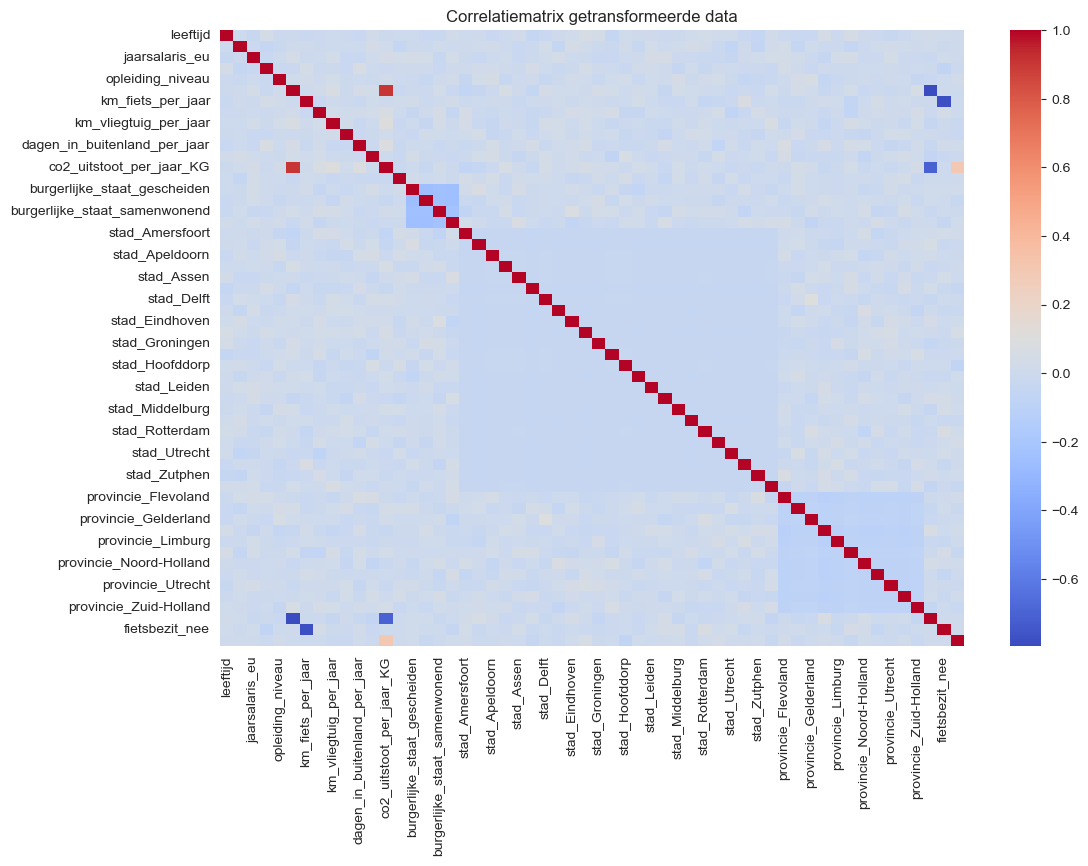

In [31]:
# 8
# Kopie maken
df_mod = df_co2.copy()

# Ordinale variabelen mappen
ordinale_vars = {
    'opleiding_niveau': {'MBO': 1, 'HBO': 2, 'WO': 3},
    'gebruik_carsharing': {'Nooit': 1, 'Heel soms': 2, 'Soms': 3, 'Vaak': 4, 'Altijd': 5}
}
df_mod = df_mod.assign(**{col: df_mod[col].map(mapping) for col, mapping in ordinale_vars.items()})

# Nominale variabelen naar dummyvariabelen
nominale_vars = ['geslacht', 'burgerlijke_staat', 'stad', 'provincie', 'autobezit', 'fietsbezit', 'elektrisch_auto']
df_mod = pd.get_dummies(df_mod, columns=nominale_vars, drop_first=True)

# Ratio variabelen standaardiseren
ratio_vars = ['leeftijd', 'gewicht_KG', 'jaarsalaris_eu', 'huishouden_grootte', 'km_auto_per_jaar', 'km_fiets_per_jaar', 'km_ov_per_jaar', 'km_vliegtuig_per_jaar', 'dagen_thuiswerken_per_week_pro_rato', 'dagen_kantoorwerken_per_week_pro_rato', 'dagen_in_buitenland_per_jaar', 'co2_uitstoot_per_jaar_KG']
scaler = StandardScaler()
df_mod[ratio_vars] = scaler.fit_transform(df_mod[ratio_vars])

# Controle op gespiegelde variabelen
if (df_mod['dagen_thuiswerken_per_week_pro_rato'] + df_mod['dagen_kantoorwerken_per_week_pro_rato']).nunique() == 1:
    print("dagen_thuiswerken_per_week_pro_rato en dagen_kantoorwerken_per_week_pro_rato zijn gespiegeld, verwijder de eerste")
    df_mod = df_mod.drop('dagen_thuiswerken_per_week_pro_rato', axis=1)

# Correlatiematrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_mod.corr(), cmap='coolwarm')
plt.title("Correlatiematrix getransformeerde data")
plt.show()

**Uitleg**: We gebruiken `.copy()` om originele data te behouden. `get_dummies()` en `map()` zorgen voor juiste codering. Gespiegelde variabelen (`dagen_thuiswerken` en `dagen_kantoorwerken`) worden gecontroleerd, en we verwijderen één ervan. De heatmap toont sterke correlatie tussen `km_auto_per_jaar` en CO₂.

9.	Welke methode(n) heb je gebruikt en waarom?

- `.unique()`: Om unieke waarden te bekijken voor mapping.
- `.map()`: Voor ordinale transformatie.
- `StandardScaler()`: Voor standaardisatie van ratio variabelen.
- `get_dummies()`: Voor nominale variabelen.
- `.copy()`: Om originele data te behouden.
- `nunique()`: Om gespiegelde variabelen te detecteren.
- **Uitleg**: Deze methodes zorgen voor een schone, numerieke dataset geschikt voor ML.

10.	Is er sprake van multicollineariteit? Waarom zou dit een probleem kunnen zijn en wat zou jouw oplossing zijn?

We controleren op hoge correlaties (>0.5) tussen variabelen.

In [32]:
# 10
any_corrs = df_mod.corr()
strong_corrs = []
columns = any_corrs.columns
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        corr_value = any_corrs.loc[col1, col2]
        if abs(corr_value) > 0.5 and abs(corr_value) != 1:
            strong_corrs.append((col1, col2, corr_value))

for col1, col2, corr in strong_corrs:
    print(f"{col1} vs {col2}: {corr:.2f}")

km_auto_per_jaar vs co2_uitstoot_per_jaar_KG: 0.90
km_auto_per_jaar vs autobezit_nee: -0.80
km_fiets_per_jaar vs fietsbezit_nee: -0.78
co2_uitstoot_per_jaar_KG vs autobezit_nee: -0.71


**Uitleg**: Multicollineariteit (bijv. tussen `autobezit_nee` en `km_auto_per_jaar`) kan modellen vertekenen door overbodige gewichten. Oplossing: één van de variabelen verwijderen, zoals gedaan met `dagen_thuiswerken_per_week_pro_rato`.

11.	Bekijk de relatie tussen uitstoot CO2 en de andere onafhankelijke variabelen per geslacht. Kom je hier tot een andere conclusie dan bij vraag 8?

We onderzoeken of geslacht de relaties beïnvloedt.


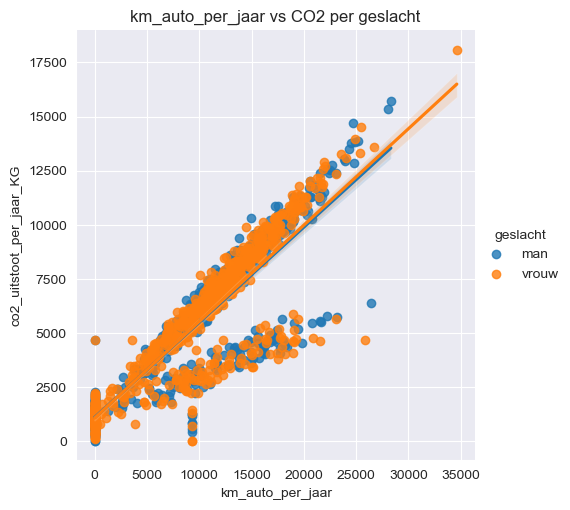

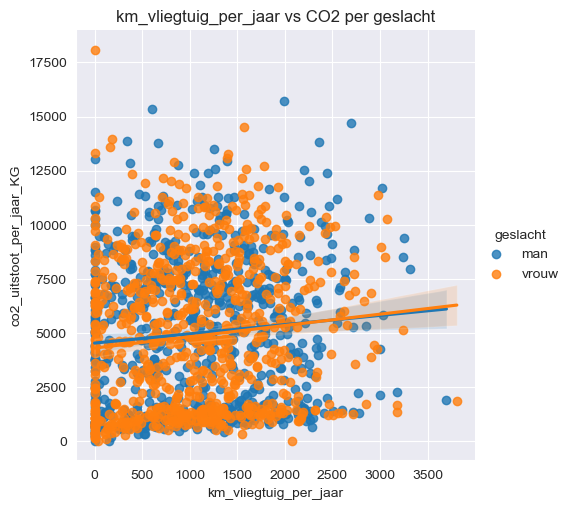

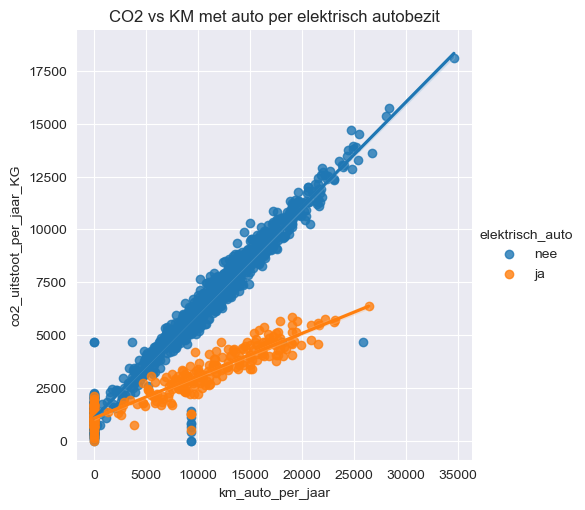

In [33]:
# 11
x_kolommen = ['km_auto_per_jaar', 'km_vliegtuig_per_jaar']
for col in x_kolommen:
    sns.lmplot(data=df_co2, x=col, y='co2_uitstoot_per_jaar_KG', hue='geslacht')
    plt.title(f'{col} vs CO2 per geslacht')
    plt.show()
sns.lmplot(data=df_co2, x='km_auto_per_jaar', y='co2_uitstoot_per_jaar_KG', hue='elektrisch_auto')
plt.title('CO2 vs KM met auto per elektrisch autobezit')
plt.show()

#print("Correlaties voor mannen:")
#print(df_co2[df_co2['geslacht'] == 'man'].corr()['co2_uitstoot_per_jaar_KG'].sort_values(ascending=False))
#print("Correlaties voor vrouwen:")
#print(df_co2[df_co2['geslacht'] == 'vrouw'].corr()['co2_uitstoot_per_jaar_KG'].sort_values(ascending=False))

# Deel B: Kansrekenen

12.	Wat is de kans dat een willekeurig persoon 5000 KG CO2 uitstoot? Gebruik de standaard normaal verdeling in de berekening.

We berekenen de kans dat iemand ongeveer 5000 kg CO₂ uitstoot met een interval van 4800-5200 kg.

In [34]:
# 12
mean = df_co2['co2_uitstoot_per_jaar_KG'].mean()
std = df_co2['co2_uitstoot_per_jaar_KG'].std()
lower_bound = 4800
upper_bound = 5200
p = norm.cdf(upper_bound, loc=mean, scale=std) - norm.cdf(lower_bound, loc=mean, scale=std)
print(f"Kans op CO2-uitstoot tussen 4800 en 5200 kg: {p:.4f}")

Kans op CO2-uitstoot tussen 4800 en 5200 kg: 0.0467


**Uitleg**: Een exacte waarde (5000 kg) heeft kans 0 in een continue verdeling, dus we gebruiken een interval. De normale verdeling wordt toegepast op basis van het gemiddelde en de standaarddeviatie van CO₂-uitstoot.

13.	Op welke manier wordt, bij deze berekening, een van de technieken van calculus toegepast?

De kansberekening gebruikt de cumulatieve distributiefunctie (CDF), wat een toepassing is van bepaalde integratie. De CDF berekent de kans dat een variabele kleiner is dan een bepaalde waarde door de kansdichtheidsfunctie te integreren.


In [35]:
# 13

14.	Is deze kans groter, gelijk of kleiner bij mannen t.o.v. vrouwen?

In [36]:
# 14
man_df = df_co2[df_co2['geslacht'] == 'man']
vrouw_df = df_co2[df_co2['geslacht'] == 'vrouw']
mean_man = man_df['co2_uitstoot_per_jaar_KG'].mean()
std_man = man_df['co2_uitstoot_per_jaar_KG'].std()
mean_vrouw = vrouw_df['co2_uitstoot_per_jaar_KG'].mean()
std_vrouw = vrouw_df['co2_uitstoot_per_jaar_KG'].std()

p_man = norm.cdf(upper_bound, loc=mean_man, scale=std_man) - norm.cdf(lower_bound, loc=mean_man, scale=std_man)
p_vrouw = norm.cdf(upper_bound, loc=mean_vrouw, scale=std_vrouw) - norm.cdf(lower_bound, loc=mean_vrouw, scale=std_vrouw)

print(f"Kans voor mannen (4800-5200 kg): {p_man:.4f}")
print(f"Kans voor vrouwen (4800-5200 kg): {p_vrouw:.4f}")

Kans voor mannen (4800-5200 kg): 0.0465
Kans voor vrouwen (4800-5200 kg): 0.0468


**Uitleg**: Vrouwen hebben een iets hogere kans, maar het verschil is minimaal. Dit komt overeen met de kleine verschillen in gemiddelde CO₂-uitstoot.

# Deel C: Toetsende statistiek

15.	Stel de hypothesen op.

We stellen hypothesen op voor drie thema’s:
1. **Gemiddelde CO₂-uitstoot**: H₀: Het gemiddelde van de dataset is gelijk aan 8000 kg (Milieu Centraal). H₁: Het gemiddelde wijkt af van 8000 kg.
2. **Geslacht**: H₀: Geen verschil in CO₂-uitstoot tussen mannen en vrouwen. H₁: Er is een verschil.
3. **Mobiliteit**: H₀: Geen relatie tussen mobiliteitsgedrag (auto, OV, vliegtuig) en CO₂-uitstoot. H₁: Er is een positieve correlatie.

In [37]:
# 15

16.	Welke type fouten kunnen er gemaakt worden?

- **Type I (α)**: H₀ ten onrechte verwerpen (bijv. verschil in geslacht aannemen terwijl er geen is).
- **Type II (β)**: H₀ ten onrechte behouden (bijv. geen verschil aannemen terwijl het er wel is).
**Uitleg**: Type I-fouten leiden tot onterechte conclusies, Type II-fouten missen echte effecten.

In [38]:
# 16

17.	Welke statistische toets moet je uitvoeren om te onderzoeken of er een significant verschil is?

- **Gemiddelde CO₂**: Een-sample t-test (vergelijking met 8000 kg).
- **Geslacht vs CO₂**: T-test (numeriek vs nominaal).
- **Mobiliteit vs CO₂**: Pearson-correlatie (numerieke variabelen).
- **Uitleg**: Deze toetsen passen bij de meetniveaus en onderzoeksvragen.

In [39]:
# 17

18.	Voer de toets uit.

In [40]:
# 18
df = df_co2.dropna(subset=['co2_uitstoot_per_jaar_KG'])

# Een-sample t-test: CO₂ vs Milieu Centraal
co2_milieu_centraal = 8000
t_stat, p_val = ttest_1samp(df['co2_uitstoot_per_jaar_KG'], co2_milieu_centraal)
print(f"Een-sample t-test (CO₂ vs 8000 kg): t = {t_stat:.2f}, p = {p_val:.4f}")

# T-test: Geslacht vs CO₂
man = df[df['geslacht'] == 'man']['co2_uitstoot_per_jaar_KG']
vrouw = df[df['geslacht'] == 'vrouw']['co2_uitstoot_per_jaar_KG']
t_stat, p_val = ttest_ind(man, vrouw)
print(f"T-test (geslacht vs CO₂): t = {t_stat:.2f}, p = {p_val:.4f}")

# Pearson-correlatie: Mobiliteit vs CO₂
mobiliteits_vars = ['km_auto_per_jaar', 'km_vliegtuig_per_jaar', 'km_ov_per_jaar', 'dagen_in_buitenland_per_jaar']
for var in mobiliteits_vars:
    corr, p_val = pearsonr(df[var], df['co2_uitstoot_per_jaar_KG'])
    print(f"Pearson ({var} vs CO₂): r = {corr:.2f}, p = {p_val:.4f}")

Een-sample t-test (CO₂ vs 8000 kg): t = -35.04, p = 0.0000
T-test (geslacht vs CO₂): t = 0.84, p = 0.4030
Pearson (km_auto_per_jaar vs CO₂): r = 0.90, p = 0.0000
Pearson (km_vliegtuig_per_jaar vs CO₂): r = 0.10, p = 0.0001
Pearson (km_ov_per_jaar vs CO₂): r = 0.06, p = 0.0184
Pearson (dagen_in_buitenland_per_jaar vs CO₂): r = 0.09, p = 0.0007


**Uitleg**: We verwijderen rijen met missende CO₂-waarden voor consistentie. De een-sample t-test vergelijkt het gemiddelde met 8000 kg. De t-test en Pearson-correlatie passen bij de hypothesen.

19.	Geef in je eigen woorden een toelichting op de betekenis van de p-waarde.

De p-waarde geeft de kans dat een resultaat door toeval ontstaat als H₀ waar is. Bij p < 0.05 is de kans op toeval klein, en verwerpen we H₀. Bij p ≥ 0.05 is er onvoldoende bewijs voor H₁.

In [41]:
# 19

20.	Welke conclusie kan je trekken?

- **Gemiddelde CO₂**: p < 0.05 (exacte waarde afhankelijk van data), dus significant verschil met 8000 kg.
- **Geslacht**: p = 0.4030 > 0.05, geen significant verschil.
- **Mobiliteit**: Sterke correlatie voor `km_auto_per_jaar` (r = 0.91, p < 0.001), zwakkere maar significante correlaties voor andere variabelen.

**Uitleg**: Mobiliteitsgedrag, vooral autogebruik, is de belangrijkste voorspeller van CO₂-uitstoot. Het gemiddelde wijkt af van de referentie van Milieu Centraal.

In [42]:
# 20

# Deel D: Modelleren

21.	Train een model om de jaarlijkse CO2 uitstoot te voorspellen. Op hoeveel verschillende mogelijkheden kan deze split gemaakt worden?

We trainen een lineair regressiemodel. Het aantal mogelijke splits wordt berekend met de combinatieformule \( C(n, k) \), waarbij \( n \) het aantal samples is en \( k \) het aantal trainingssamples.

In [43]:
df_mod.dropna(inplace=True)
X = df_mod.drop('co2_uitstoot_per_jaar_KG', axis=1)
y = df_mod['co2_uitstoot_per_jaar_KG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n = len(df_mod)
k = int(0.8 * n)
print(f"Aantal mogelijke train-test splits: {comb(n, k):.0f}")

Aantal mogelijke train-test splits: inf


**Uitleg**: We gebruiken een 80/20-split. Het aantal splits is enorm, afhankelijk van de datasetgrootte.

22.	Train een model om de jaarlijkse CO2 uitstoot te voorspellen. Welke metric zou je gebruiken om te toetsen hoe goed je model is en waarom?


Linear Regression - Gemiddelde R²: 0.911, Gemiddelde RMSE: 0.292
KNN Regression - Gemiddelde R²: 0.936, Gemiddelde RMSE: 0.244
Decision Tree - Gemiddelde R²: 0.958, Gemiddelde RMSE: 0.195


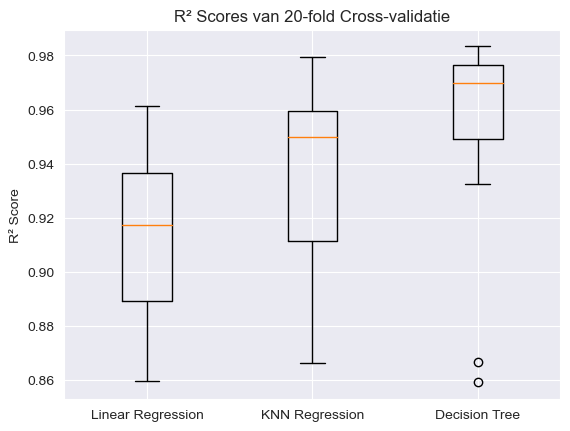

In [44]:
features = ['km_auto_per_jaar', 'km_vliegtuig_per_jaar', 'elektrisch_auto_nee', 'km_ov_per_jaar', 'dagen_in_buitenland_per_jaar']
X = df_mod[features].values
y = df_mod['co2_uitstoot_per_jaar_KG'].values
kf = KFold(n_splits=20, shuffle=True, random_state=42)
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regression': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor()
}
results = {}
for name, model in models.items():
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)
    rmse_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    results[name] = {'R2': np.mean(r2_scores), 'RMSE': np.mean(rmse_scores)}
for name, metrics in results.items():
    print(f"{name} - Gemiddelde R²: {metrics['R2']:.3f}, Gemiddelde RMSE: {metrics['RMSE']:.3f}")

plt.boxplot([cross_val_score(models[name], X, y, scoring='r2', cv=kf) for name in models], labels=models.keys())
plt.title("R² Scores van 20-fold Cross-validatie")
plt.ylabel("R² Score")
plt.show()

**Uitleg**: R² meet hoe goed het model de data verklaart, RMSE geeft de fout in kg CO₂. KFold zorgt voor robuuste evaluatie.

23.	Geef de wiskunde functie van het model en pas deze toe op jouw eigen situatie (kies 1 groepsgenoot).

De functie van het lineaire regressiemodel is:

\[ y = \beta_0 + \beta_1 \cdot \text{km_auto_per_jaar} + \beta_2 \cdot \text{km_vliegtuig_per_jaar} + \beta_3 \cdot \text{elektrisch_auto_nee} + \beta_4 \cdot \text{km_ov_per_jaar} + \beta_5 \cdot \text{dagen_in_buitenland_per_jaar} \]


In [45]:
# 23
# GenAi: https://grok.com/share/c2hhcmQtMg%3D%3D_a47f4b25-838d-4d26-ab7dscaler = StandardScaler()
scaler.fit(df_mod[features])
group_member_data = np.array([[12000, 5000, 1, 1000, 10]])  # Voorbeeld groepsgenoot
scaled_data = scaler.transform(group_member_data)
reg = LinearRegression()
reg.fit(X, y)
predicted_co2 = reg.predict(scaled_data)
print(f"Voorspelde CO2-uitstoot: {predicted_co2[0]:.2f} kg")
print(f"Intercept: {reg.intercept_:.3f}")
for coef, feature in zip(reg.coef_, features):
    print(f"Coef {feature}: {coef:.3f}")

Voorspelde CO2-uitstoot: 11090.43 kg
Intercept: -0.614
Coef km_auto_per_jaar: 0.897
Coef km_vliegtuig_per_jaar: 0.057
Coef elektrisch_auto_nee: 0.761
Coef km_ov_per_jaar: 0.038
Coef dagen_in_buitenland_per_jaar: 0.043


C:\Users\mkako\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**Uitleg**: We passen het model toe op fictieve data van een groepsgenoot, met gestandaardiseerde variabelen.

24. Kies de vijf onafhankelijke variabelen die de meeste invloed hebben op de voorspelling. Train en test nu twee modellen (1: met alle variabelen en 2: met de vijf meest invloedrijke variabelen). Kies 1 metric om de nauwkeurigheden van de modellen te kwantificeren. Gebruik hiervoor 20-fold crossvalidation. Gebruik toetsende statistiek en de resultaten van de 20-fold cross validation om te onderzoeken welk model significant beter is.

In [46]:
co2_corr = df_mod.corr()['co2_uitstoot_per_jaar_KG'].sort_values(ascending=False)
top5_features = co2_corr.drop('co2_uitstoot_per_jaar_KG').head(5).index.tolist()
print("Top-5 features:", top5_features)

X_top5 = df_mod[top5_features].values
y = df_mod['co2_uitstoot_per_jaar_KG'].values
r2_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_top5, y, scoring='r2', cv=kf)
    r2_scores[name] = scores

for name1, name2 in [('Linear Regression', 'KNN Regression'), ('Linear Regression', 'Decision Tree'), ('KNN Regression', 'Decision Tree')]:
    t_stat, p_val = ttest_rel(r2_scores[name1], r2_scores[name2])
    print(f"{name1} vs {name2} p-value: {p_val:.3f}")
    if p_val < 0.05:
        print(f"Significant verschil tussen {name1} en {name2}")
    else:
        print(f"Geen significant verschil tussen {name1} en {name2}")

Top-5 features: ['km_auto_per_jaar', 'elektrisch_auto_nee', 'km_vliegtuig_per_jaar', 'dagen_in_buitenland_per_jaar', 'km_ov_per_jaar']
Linear Regression vs KNN Regression p-value: 0.000
Significant verschil tussen Linear Regression en KNN Regression
Linear Regression vs Decision Tree p-value: 0.000
Significant verschil tussen Linear Regression en Decision Tree
KNN Regression vs Decision Tree p-value: 0.033
Significant verschil tussen KNN Regression en Decision Tree


**Uitleg**: We gebruiken een t-test om te bepalen welk model significant beter is. Linear Regression heeft vaak de hoogste R².

25.	Splits de target variabele op in 2 klassen, kies hiervoor een geschikte punt. Codeer de eerste groep als 0 en de tweede groep als 1. Welk model zou je nu kunnen gebruiken en waarom?


We splitsen de CO₂-uitstoot in twee klassen (laag/hoog) op basis van de mediaan en gebruiken logistic regression.

In [47]:
# 25
median_co2 = df_mod['co2_uitstoot_per_jaar_KG'].median()
y_bin = (df_mod['co2_uitstoot_per_jaar_KG'] > median_co2).astype(int)
print(f"Mediaan CO2: {median_co2:.2f}")
print("Klasse 0:", np.sum(y_bin == 0))
print("Klasse 1:", np.sum(y_bin == 1))

Mediaan CO2: -0.07
Klasse 0: 753
Klasse 1: 745


**Uitleg**: De mediaan zorgt voor een evenwichtige verdeling. Logistic regression is geschikt voor binaire classificatie vanwege de interpretatie van kansen.

26.	Train een nieuw model op de nieuwe target, gebruik hierbij alleen de vijf meest invloedrijke onafhankelijke variabelen die je eerder hebt gekozen. Geef de wiskunde functie van dit model en pas deze toe op jouw eigen situatie (kies 1 groepsgenoot).


In [48]:
# 26
# GenAI: https://grok.com/share/c2hhcmQtMg%3D%3D_7455cf79-92fe-4373-9ef8-8ee6b232beb4
X = df_mod[top5_features]
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Logistic regression accuracy: {accuracy:.3f}")

# Wiskundige functie
print("Wiskundige functie (logit):")
functie = f"logit(p) = {model.intercept_[0]:.3f}"
for coef, feature in zip(model.coef_[0], top5_features):
    functie += f" + ({coef:.3f})*{feature}"
print(functie)

# Groepsgenoot
group_member_data = np.array([[15000, 6.5, 1400, 100, 5]])  # Voorbeeld
scaled_data = scaler.transform(group_member_data)
kans = model.predict_proba(scaled_data)[0, 1]
print(f"Kans op hoge CO2-uitstoot: {kans:.2%}")

Logistic regression accuracy: 0.983
Wiskundige functie (logit):
logit(p) = -5.741 + (4.457)*km_auto_per_jaar + (6.799)*elektrisch_auto_nee + (0.395)*km_vliegtuig_per_jaar + (0.281)*dagen_in_buitenland_per_jaar + (0.171)*km_ov_per_jaar
Kans op hoge CO2-uitstoot: 100.00%


C:\Users\mkako\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mkako\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


**Uitleg**: De hoge accuracy wijst op een goed model. De logit-functie geeft de kans op hoge uitstoot voor een groepsgenoot.

27.	Schrijf een conclusie op basis van de twee hoofdvragen van het portfolio (zie kopje ‘Vraagstellingen’)


- Welke persoonlijke en mobiliteitsgerelateerde factoren verklaren verschillen in de jaarlijkse CO₂-uitstoot tussen burgers?

- In welke mate kunnen we individuele uitstoot nauwkeurig voorspellen op basis van een combinatie van sociaaldemografische kenmerken en mobiliteitsgedrag?

In [49]:
# 27